In [53]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from utils_tensorflow import *
from utils import *

mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# ticker = 'AAPL'
# HISTORY_START_DATE = '2012-01-01'

# df = si.get_data(ticker)
# df = df[df.index >= HISTORY_START_DATE]
# df['adjclose'].dropna(inplace=True)

In [13]:
ticker = 'AAPL' # ^GSPC is S&P 500 ticker
HISTORY_START_DATE = '2012-01-01'

# df = si.get_data(ticker)
df = load_ticker_data(ticker)
df = df[df.index >= HISTORY_START_DATE]
df['adjclose'].dropna(inplace=True)
df.tail()

Data imported from file.


,open,high,low,close,adjclose,volume,ticker
2020-06-12,344.720001,347.799988,334.220001,338.799988,338.799988,50001500.0,AAPL
2020-06-15,333.250000,345.679993,332.579987,342.989990,342.989990,34702200.0,AAPL
2020-06-16,351.459991,353.200012,344.720001,352.079987,352.079987,41357200.0,AAPL
2020-06-17,355.149994,355.399994,351.089996,351.589996,351.589996,28532000.0,AAPL
2020-06-18,351.410004,353.444397,350.320007,351.609985,351.609985,12898658.0,AAPL


Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002523B9ED7B8>],
      dtype=object)

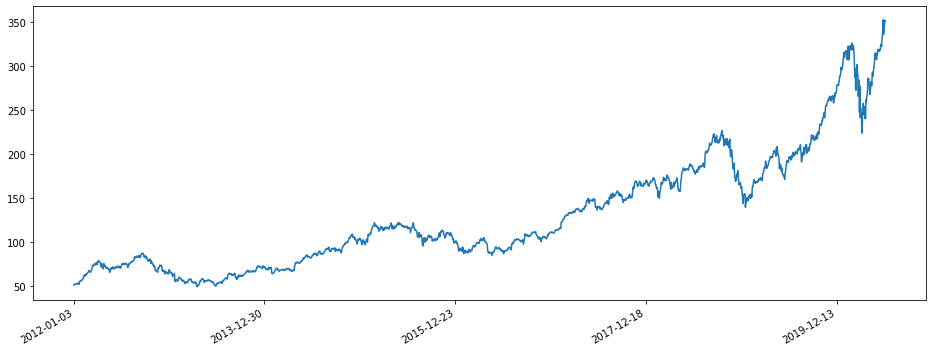

In [15]:
df['adjclose'].plot(subplots=True)

## Prepare data

In [16]:
features_considered = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
features = df[df['open'].isna()==False][features_considered]
features = features[features.index > '2012-01-01']
features.tail(3)

,open,high,low,close,adjclose,volume
2020-06-16,351.459991,353.200012,344.720001,352.079987,352.079987,41357200.0
2020-06-17,355.149994,355.399994,351.089996,351.589996,351.589996,28532000.0
2020-06-18,351.410004,353.444397,350.320007,351.609985,351.609985,12898658.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025222B08EB8>,
      dtype=object)

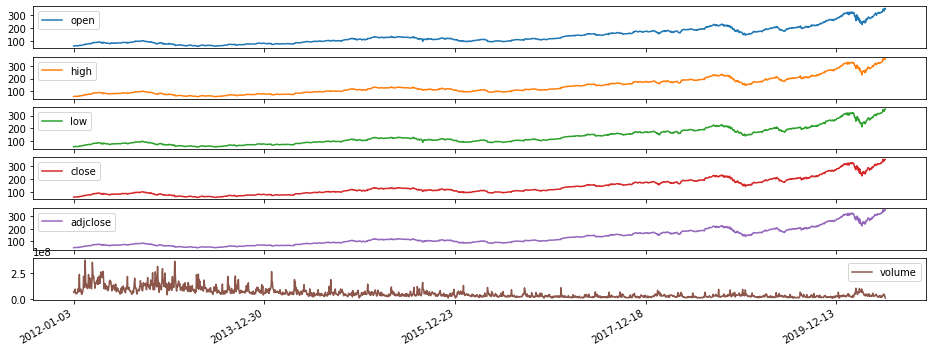

In [17]:
features.plot(subplots=True)

- Standardize data using Min Max Scaler

In [18]:
data_scaled = features.copy()

TRAIN_SPLIT = int(df.shape[0] * 0.75)
print(f"TRAIN_SPLIT: {TRAIN_SPLIT}, TEST SPLIT: {df.shape[0] - TRAIN_SPLIT}")

column_scaler = {}
# scale the data (prices) from 0 to 1
for column in data_scaled.columns:
    
    column_values = data_scaled[column].values.reshape(-1, 1)
    # Fit only on training data
    scaler = MinMaxScaler()
    scaler.fit(column_values[:TRAIN_SPLIT])
    data_scaled[column] = scaler.transform(column_values)
    column_scaler[column] = scaler

data_scaled.tail(3)

TRAIN_SPLIT: 1596, TEST SPLIT: 533


,open,high,low,close,adjclose,volume
2020-06-16,2.281485,2.267611,2.233045,2.290253,2.321835,0.081854
2020-06-17,2.309923,2.284458,2.282145,2.286465,2.318081,0.046722
2020-06-18,2.281100,2.269482,2.276210,2.286620,2.318235,0.003897


### Split data in batches for training

In [19]:
target_variable = 'adjclose'
target_var_index = data_scaled.columns.tolist().index(target_variable)

target = data_scaled[target_variable].values
dataset = data_scaled.values

past_history = 30
future_target = 7
BATCH_SIZE = 64
BUFFER_SIZE = 1000

LAST_SEQUENCE = dataset.shape[0] - 1 - past_history
TEST_SPLIT = LAST_SEQUENCE - 3 * past_history

train_data = prepare_batches(dataset, target,
                             0, TRAIN_SPLIT,
                             past_history, future_target)
val_data = prepare_batches(dataset, target,
                           TRAIN_SPLIT, TEST_SPLIT,
                           past_history, future_target)
test_data = prepare_batches(dataset, target,
                            TEST_SPLIT, LAST_SEQUENCE,
                            past_history, future_target)

# Dataset to predict prices after last datapoint
real_predict_data = prepare_test_batch(dataset, LAST_SEQUENCE, None,  past_history)

In [50]:
train_data

<RepeatDataset shapes: ((None, 30, 6), (None, 7)), types: (tf.float64, tf.float64)>

In [44]:
test_data

<RepeatDataset shapes: ((None, 30, 6), (None, 7)), types: (tf.float64, tf.float64)>

- Prepare dates (index for plots)

In [23]:
dates = data_scaled[data_scaled.index > HISTORY_START_DATE].index
try: 
    dates = np.array(dates.date, 'str')
except:
    pass

train_dates = prepare_dates(dates, 0, TRAIN_SPLIT, 
                            past_history, future_target)
val_dates = prepare_dates(dates, TRAIN_SPLIT, TEST_SPLIT, 
                          past_history, future_target)
test_dates = prepare_dates(dates, TEST_SPLIT, LAST_SEQUENCE, 
                          past_history, future_target)
real_predict_dates = prepare_dates(dates, LAST_SEQUENCE, None, 
                                   past_history, future_target)
real_predict_dates

<RepeatDataset shapes: ((None, 30, 1), (None, 7)), types: (tf.string, tf.string)>

History date range: 2012-01-03 00:00:00, 2012-02-14 00:00:00
Future date range: 2012-02-15 00:00:00, 2012-02-24 00:00:00


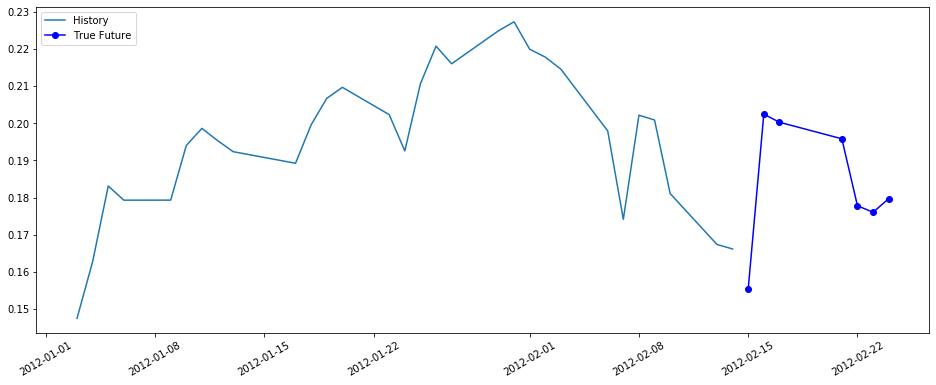

In [24]:
for xy, date in zip(train_data.take(1), train_dates.take(1)):
    
    x, y = xy
    x_dates, y_dates = date
    history = np.array(x[0])[:, target_var_index]
    true_future = np.array(y[0])
    
    multi_step_plot_dates(x_dates[0].numpy(), history, y_dates[0].numpy(), true_future)

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [25]:
input_shape = (past_history, len(features_considered))
input_shape

(30, 6)

In [119]:
baseline_model = tf.keras.models.Sequential()
baseline_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=input_shape))
baseline_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
baseline_model.add(tf.keras.layers.LSTM(32, activation='relu'))
baseline_model.add(tf.keras.layers.Dense(future_target))

# baseline_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
optimizer = keras.optimizers.Adam(learning_rate=5e-5)
baseline_model.compile(optimizer=optimizer, loss='mae', 
                       metrics=["MeanAbsolutePercentageError", "RootMeanSquaredError"])
baseline_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_139 (LSTM)              (None, 30, 32)            4992      
_________________________________________________________________
lstm_140 (LSTM)              (None, 30, 32)            8320      
_________________________________________________________________
lstm_141 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dense_30 (Dense)             (None, 7)                 231       
Total params: 21,863
Trainable params: 21,863
Non-trainable params: 0
_________________________________________________________________


In [120]:
for x, y in val_data.take(1):
    print(baseline_model.predict(x).shape)

(64, 7)


In [121]:
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

history = baseline_model.fit(train_data, epochs=50,
                             steps_per_epoch=100,
                             validation_data=val_data,
                             validation_steps=50,
                             callbacks=[early_stopping])

Train for 100 steps, validate for 50 steps
Epoch 1/50
100/100 [==============================] - 9s 92ms/step - loss: 0.3686 - MeanAbsolutePercentageError: 6736.6826 - RootMeanSquaredError: 0.4424 - val_loss: 1.0861 - val_MeanAbsolutePercentageError: 92.3830 - val_RootMeanSquaredError: 1.1136
Epoch 2/50
100/100 [==============================] - 7s 72ms/step - loss: 0.2349 - MeanAbsolutePercentageError: 31617.5371 - RootMeanSquaredError: 0.3140 - val_loss: 0.3573 - val_MeanAbsolutePercentageError: 29.9624 - val_RootMeanSquaredError: 0.4378
Epoch 3/50
100/100 [==============================] - 8s 81ms/step - loss: 0.0544 - MeanAbsolutePercentageError: 46156.9336 - RootMeanSquaredError: 0.0770 - val_loss: 0.1488 - val_MeanAbsolutePercentageError: 12.3915 - val_RootMeanSquaredError: 0.1785
Epoch 4/50
100/100 [==============================] - 8s 77ms/step - loss: 0.0381 - MeanAbsolutePercentageError: 44028.5859 - RootMeanSquaredError: 0.0486 - val_loss: 0.1434 - val_MeanAbsolutePercentage

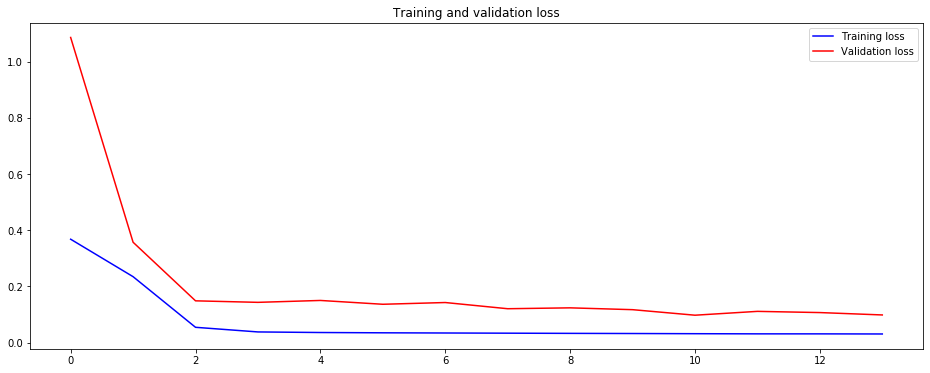

In [122]:
plot_train_history(history, 'Training and validation loss')

#### Check on validation dataset
Let's now have a look at how well your network has learnt to predict the future.

History date range: 2018-05-08 00:00:00, 2018-06-19 00:00:00
Future date range: 2018-06-20 00:00:00, 2018-06-28 00:00:00


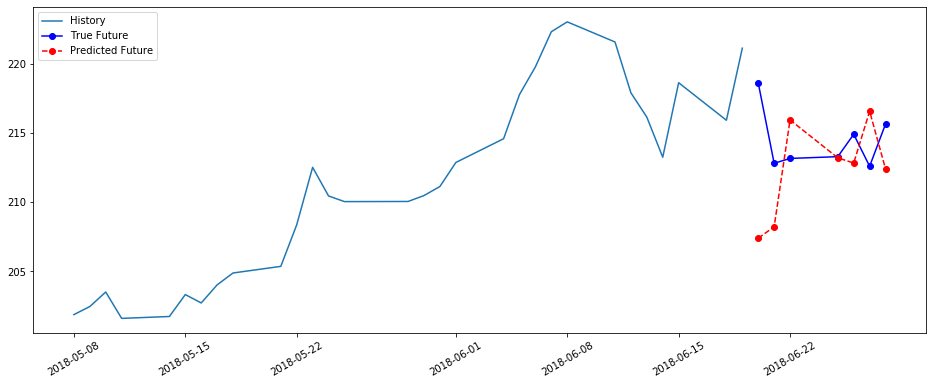

History date range: 2018-08-08 00:00:00, 2018-09-19 00:00:00
Future date range: 2018-09-20 00:00:00, 2018-09-28 00:00:00


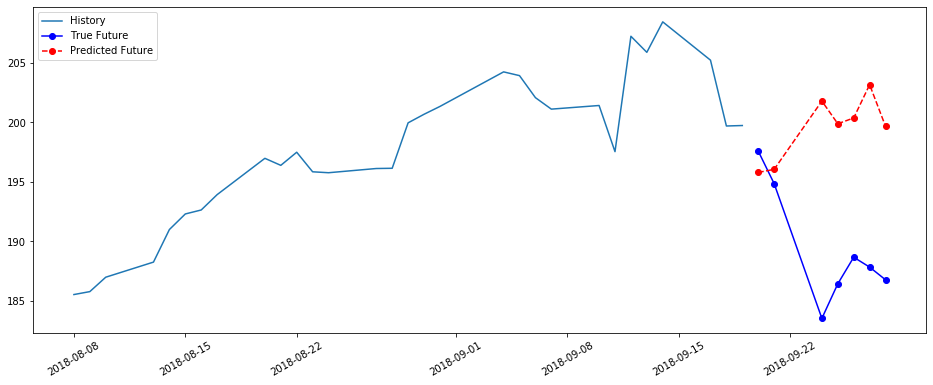

History date range: 2018-11-07 00:00:00, 2018-12-20 00:00:00
Future date range: 2018-12-21 00:00:00, 2019-01-02 00:00:00


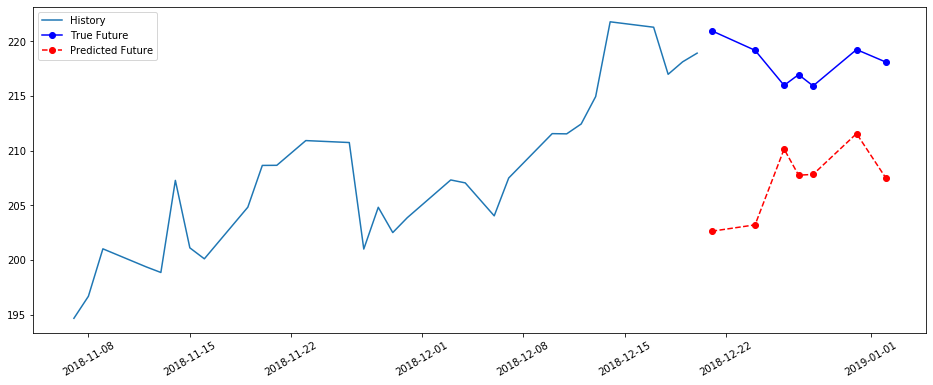

In [123]:
for xy, date in zip(val_data.take(3), val_dates.take(3)):
    
    x, y = xy
    x_dates, y_dates = date
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = baseline_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

In [42]:
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-06-12,344.720001,347.799988,334.220001,338.799988,338.799988,50001500.0,AAPL
2020-06-15,333.250000,345.679993,332.579987,342.989990,342.989990,34702200.0,AAPL
2020-06-16,351.459991,353.200012,344.720001,352.079987,352.079987,41357200.0,AAPL
2020-06-17,355.149994,355.399994,351.089996,351.589996,351.589996,28532000.0,AAPL
2020-06-18,351.410004,353.444397,350.320007,351.609985,351.609985,12898658.0,AAPL


History date range: 2020-05-06 00:00:00, 2020-06-17 00:00:00
Future date range: 2020-06-19 00:00:00, 2020-06-29 00:00:00


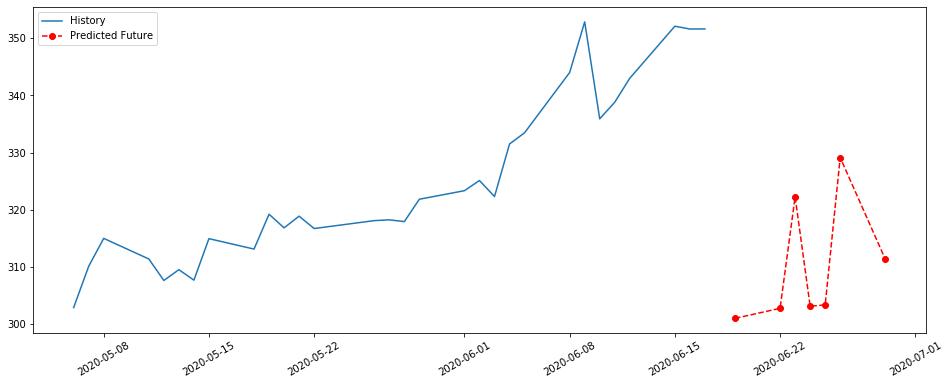

In [124]:
for x, date in zip(real_predict_data.take(1), real_predict_dates.take(1)):
    
    x_dates, y_dates = date
    history = x[0].numpy() [:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    prediction = baseline_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), prediction=prediction_rescaled)

In [125]:
evaluate_model(baseline_model, test_data, 'mae', ['mape', 'rmse'], 'baseline')

,mae,mape,rmse,hyperparams
0,0.237063,14.072865,0.275527,baseline


# 2. Model

In [92]:
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [21]:
param_distribs = {
    'n_hidden': [2, 3, 4, 5, 6]
    ,'n_neurons': [8, 16, 32, 64]
    ,'learning_rate': np.arange(1e-3, 1e-1, 1e-3)
    ,'bidirectional': [True, False]
#     ,'dropout': [0.3, 0.5]
#     ,'optimizer': ['adam', 'rmsprop', 'SGD']
#     ,'output_layer_activation': ['linear', 'relu']
}

In [23]:
tensorboard_cb = TensorBoard(get_run_dir('logs'))
checkpointer_cb = ModelCheckpoint(get_run_dir('models'), save_best_only=True)
earlystopping_cb = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)


In [130]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=1e-4, s=5)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [24]:
input_shape = (past_history, len(features_considered))

In [138]:
testing_model = build_model(n_hidden=3, n_neurons=32,
                            bidirectional=True,
                            learning_rate=5e-5,
                            input_shape=input_shape,
                            output_layer_neurons=future_target)
testing_model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_140 (Bidirecti (None, 30, 64)            9984      
_________________________________________________________________
bidirectional_141 (Bidirecti (None, 30, 64)            24832     
_________________________________________________________________
dropout_114 (Dropout)        (None, 30, 64)            0         
_________________________________________________________________
bidirectional_142 (Bidirecti (None, 30, 64)            24832     
_________________________________________________________________
dropout_115 (Dropout)        (None, 30, 64)            0         
_________________________________________________________________
bidirectional_143 (Bidirecti (None, 64)                24832     
_________________________________________________________________
dropout_116 (Dropout)        (None, 64)              

In [139]:
history = testing_model.fit(train_data, epochs=50,
                  steps_per_epoch=300,
                  validation_data=val_data,
                  validation_steps=50,
                  callbacks=[earlystopping_cb, lr_scheduler],
                  verbose=1)

Train for 300 steps, validate for 50 steps
Epoch 1/50
300/300 [==============================] - 46s 152ms/step - loss: 0.1005 - MeanAbsolutePercentageError: 39210.1680 - RootMeanSquaredError: 0.1554 - val_loss: 0.1818 - val_MeanAbsolutePercentageError: 14.2450 - val_RootMeanSquaredError: 0.2284
Epoch 2/50
300/300 [==============================] - 33s 110ms/step - loss: 0.0657 - MeanAbsolutePercentageError: 38817.2617 - RootMeanSquaredError: 0.0941 - val_loss: 0.1571 - val_MeanAbsolutePercentageError: 12.4554 - val_RootMeanSquaredError: 0.1959
Epoch 3/50
300/300 [==============================] - 33s 110ms/step - loss: 0.0610 - MeanAbsolutePercentageError: 38468.6289 - RootMeanSquaredError: 0.0872 - val_loss: 0.1224 - val_MeanAbsolutePercentageError: 9.8496 - val_RootMeanSquaredError: 0.1571
Epoch 4/50
300/300 [==============================] - 33s 109ms/step - loss: 0.0577 - MeanAbsolutePercentageError: 36440.1250 - RootMeanSquaredError: 0.0828 - val_loss: 0.1057 - val_MeanAbsolutePe

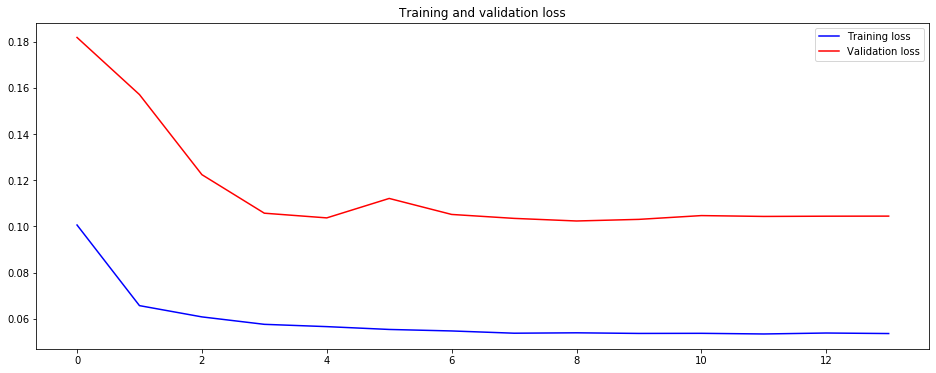

In [140]:
plot_train_history(history, 'Training and validation loss')

In [141]:
evaluate_model(testing_model, test_data, 'mae', ['mape', 'rmse'], 'testing_model')

,mae,mape,rmse,hyperparams
0,0.305422,16.70262,0.350071,testing_model


In [144]:
evaluate_model(baseline_model, test_data, 'mae', ['mape', 'rmse'], 'baseline')

,mae,mape,rmse,hyperparams
0,0.237063,14.072865,0.275527,baseline


History date range: 2018-05-08 00:00:00, 2018-06-19 00:00:00
Future date range: 2018-06-20 00:00:00, 2018-06-28 00:00:00


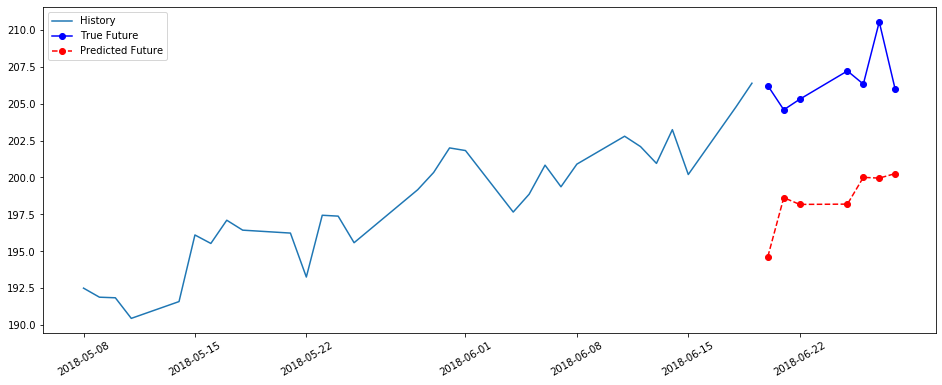

History date range: 2018-08-08 00:00:00, 2018-09-19 00:00:00
Future date range: 2018-09-20 00:00:00, 2018-09-28 00:00:00


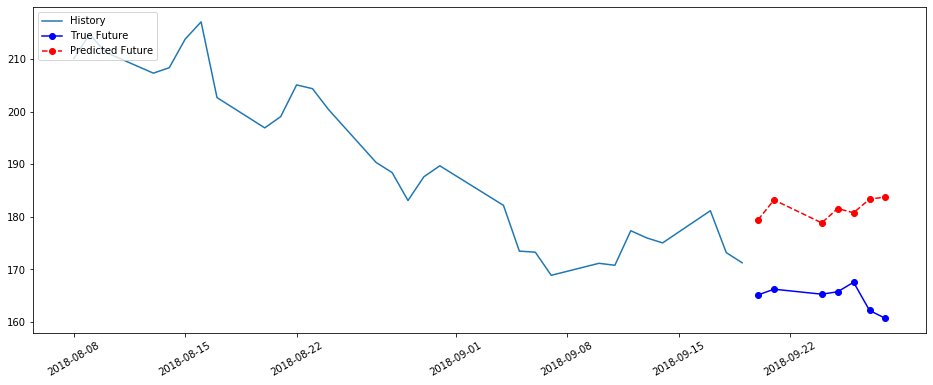

History date range: 2018-11-07 00:00:00, 2018-12-20 00:00:00
Future date range: 2018-12-21 00:00:00, 2019-01-02 00:00:00


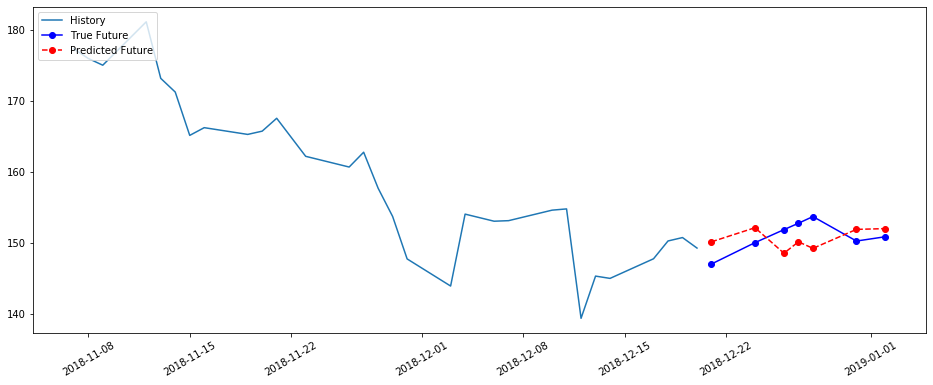

History date range: 2019-02-12 00:00:00, 2019-03-26 00:00:00
Future date range: 2019-03-27 00:00:00, 2019-04-04 00:00:00


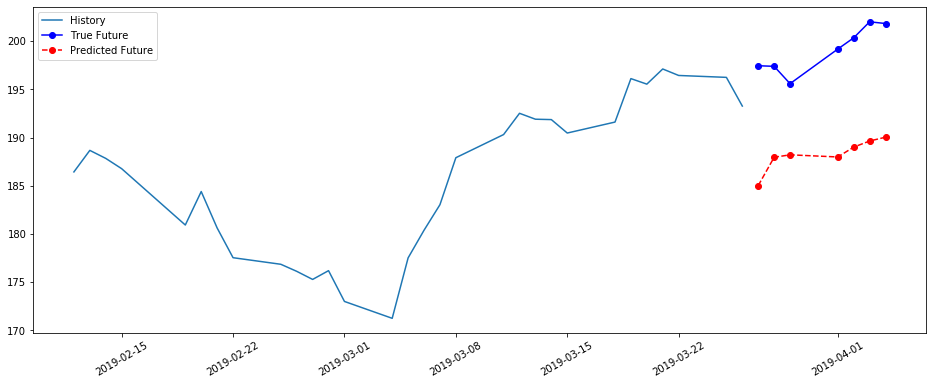

History date range: 2019-05-15 00:00:00, 2019-06-26 00:00:00
Future date range: 2019-06-27 00:00:00, 2019-07-08 00:00:00


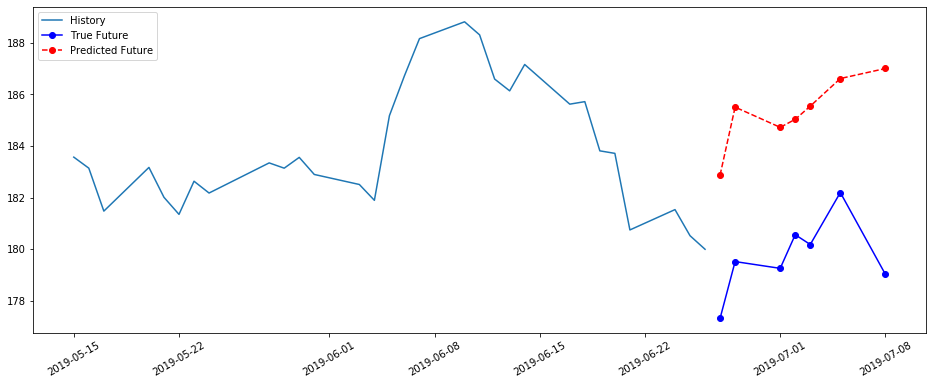

History date range: 2019-08-15 00:00:00, 2019-09-26 00:00:00
Future date range: 2019-09-27 00:00:00, 2019-10-07 00:00:00


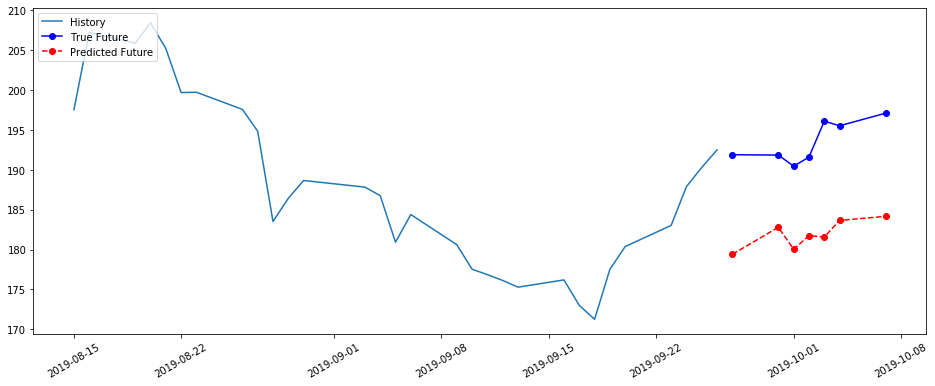

In [142]:
for xy, date in zip(val_data.take(6), val_dates.take(6)):
    
    x, y = xy
    x_dates, y_dates = date
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = testing_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

# GridSearch for Hyperparameters

In [85]:
def bidir_str(bidir):
    if bidir:
        return 'bidir' 
    else: 
        return ''

In [102]:
n_hidden = [2, 3, 4, 5, 6]
n_neurons = [8, 16, 32, 64]
learning_rate = np.arange(1e-3, 1e-1, 1e-3)
bidirectional = [True]

In [145]:
tensorboard_cb = TensorBoard(get_run_dir('logs'))
checkpointer_cb = ModelCheckpoint(get_run_dir('models'), save_best_only=True)
earlystopping_cb = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
cb_list = [earlystopping_cb, lr_scheduler]
dfsummary = []

for n_h in n_hidden:
    for n_n in n_neurons:
        for bidir in bidirectional:
            model_hyperparams = '_'.join([str(par) for par in [n_h, 'hidden', n_n, 'neurons', bidir_str(bidir)]])
            
            testing_model = build_model(n_hidden=n_h,
                                        n_neurons=n_n,
                                        bidirectional=bidir,
                                        input_shape=input_shape,
                                        output_layer_neurons=future_target)
            print('\n', '='*10, model_hyperparams, '='*10, '\n')
            testing_model.fit(
                train_data, epochs=50,
                steps_per_epoch=50,
                validation_data=val_data,
                validation_steps=50,
                callbacks=cb_list,
                verbose=1)
            summary = evaluate_model(testing_model, test_data, 'mae', ['mape', 'rmse'], model_hyperparams)
            print(summary)
            dfsummary.append(summary)


 ========== 2_hidden_8_neurons_bidir ========== 

Train for 50 steps, validate for 50 steps
Epoch 1/50
50/50 [==============================] - 13s 265ms/step - loss: 0.3135 - MeanAbsolutePercentageError: 31911.3262 - RootMeanSquaredError: 0.4077 - val_loss: 1.0034 - val_MeanAbsolutePercentageError: 84.8699 - val_RootMeanSquaredError: 1.0480
Epoch 2/50
50/50 [==============================] - 3s 56ms/step - loss: 0.2678 - MeanAbsolutePercentageError: 42561.7852 - RootMeanSquaredError: 0.3623 - val_loss: 0.9373 - val_MeanAbsolutePercentageError: 79.0176 - val_RootMeanSquaredError: 0.9862
Epoch 3/50
50/50 [==============================] - 3s 54ms/step - loss: 0.2463 - MeanAbsolutePercentageError: 48230.1016 - RootMeanSquaredError: 0.3389 - val_loss: 0.9019 - val_MeanAbsolutePercentageError: 75.8491 - val_RootMeanSquaredError: 0.9527
Epoch 4/50
50/50 [==============================] - 3s 62ms/step - loss: 0.2323 - MeanAbsolutePercentageError: 48472.8438 - RootMeanSquaredError: 0.3253 - 

50/50 [==============================] - 3s 57ms/step - loss: 0.2098 - MeanAbsolutePercentageError: 51704.3516 - RootMeanSquaredError: 0.2900 - val_loss: 0.8250 - val_MeanAbsolutePercentageError: 69.1821 - val_RootMeanSquaredError: 0.8625
Epoch 4/50
50/50 [==============================] - 3s 56ms/step - loss: 0.1844 - MeanAbsolutePercentageError: 72402.7422 - RootMeanSquaredError: 0.2606 - val_loss: 0.7772 - val_MeanAbsolutePercentageError: 64.9338 - val_RootMeanSquaredError: 0.8156
Epoch 5/50
50/50 [==============================] - 3s 58ms/step - loss: 0.1728 - MeanAbsolutePercentageError: 49305.9727 - RootMeanSquaredError: 0.2463 - val_loss: 0.7480 - val_MeanAbsolutePercentageError: 62.3400 - val_RootMeanSquaredError: 0.7875
Epoch 6/50
50/50 [==============================] - 3s 55ms/step - loss: 0.1659 - MeanAbsolutePercentageError: 43104.1602 - RootMeanSquaredError: 0.2365 - val_loss: 0.7300 - val_MeanAbsolutePercentageError: 60.7617 - val_RootMeanSquaredError: 0.7704
Epoch 7/50


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x00000252350082F0>
Traceback (most recent call last):
  File "C:\Users\jp_ko\Anaconda3\lib\weakref.py", line 357, in remove
    self = selfref()
KeyboardInterrupt


46/50 [==========================>...] - ETA: 6s - loss: 0.2089 - MeanAbsolutePercentageError: 51247.2031 - RootMeanSquaredError: 0.2832WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MeanAbsolutePercentageError,RootMeanSquaredError


KeyboardInterrupt: 

In [146]:
dfsummary

""


In [105]:
import time
print(time.now())

AttributeError: module 'time' has no attribute 'now'

# 3. Bidirectional model

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import time
import os


def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                 loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False,
                 last_layer_neurons=1, input_shape=(64, 6)):
    model = Sequential()
    
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=input_shape))
            else:
                model.add(cell(units, return_sequences=True, input_shape=input_shape))
                
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
                
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
        
    model.add(Dense(last_layer_neurons, activation="linear"))
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=["mean_absolute_error", "median_absolute_error", "rmse"])
    return model

In [32]:
# construct the model
model = create_model(past_history, loss='mae', units=256, n_layers=2,
                     optimizer="rmsprop", bidirectional=True,
                     last_layer_neurons=future_target)
print(model.summary())
# # some tensorflow callbacks
# tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

model_history = model.fit(train_data, epochs=20,
                          steps_per_epoch=200,
                          validation_data=val_data,
                          validation_steps=50,
                          callbacks=[early_stopping],
                          verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 512)           538624    
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 3591      
Total params: 2,117,127
Trainable params: 2,117,127
Non-trainable params: 0
_________________________________________________________________
None
Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 198s 988

[[2781.8518]
 [2767.66  ]
 [2783.7087]
 [2782.8203]
 [2768.0588]
 [2780.4834]
 [2792.2075]]
History date range: 2018-05-01 00:00:00, 2018-06-12 00:00:00
Future date range: 2018-06-12 00:00:00, 2018-06-20 00:00:00


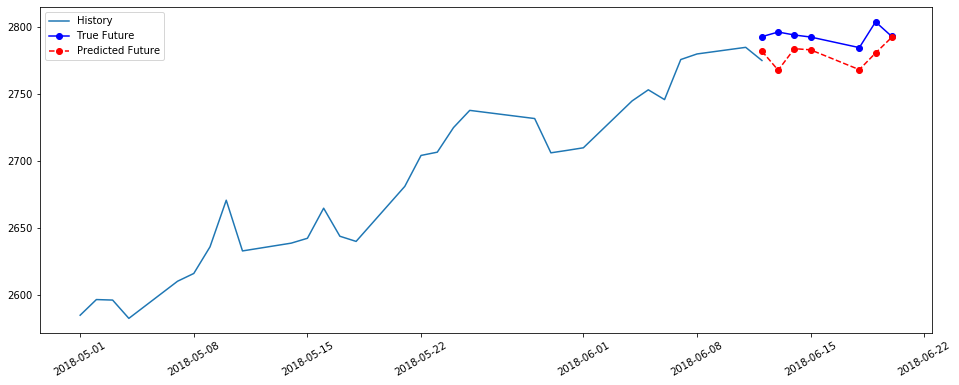

[[3029.1404]
 [3015.806 ]
 [3034.949 ]
 [3033.4912]
 [3016.0728]
 [3030.6543]
 [3045.035 ]]
History date range: 2018-08-01 00:00:00, 2018-09-12 00:00:00
Future date range: 2018-09-12 00:00:00, 2018-09-20 00:00:00


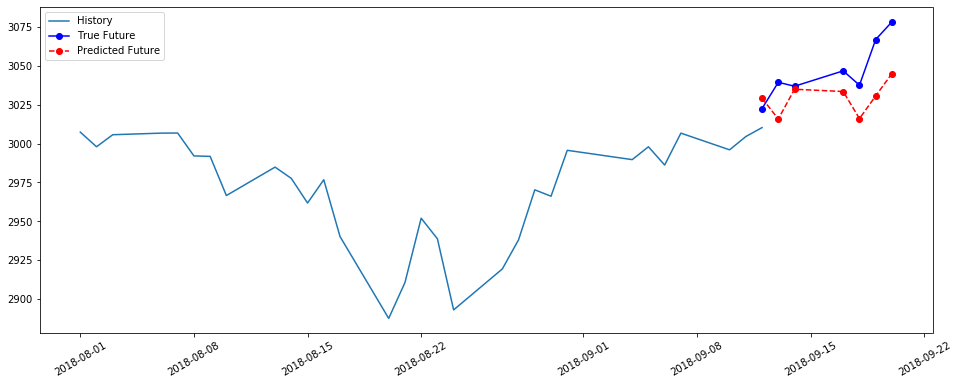

[[2761.4204]
 [2750.5266]
 [2766.7085]
 [2768.4893]
 [2753.293 ]
 [2766.457 ]
 [2777.5686]]
History date range: 2018-10-31 00:00:00, 2018-12-13 00:00:00
Future date range: 2018-12-13 00:00:00, 2018-12-21 00:00:00


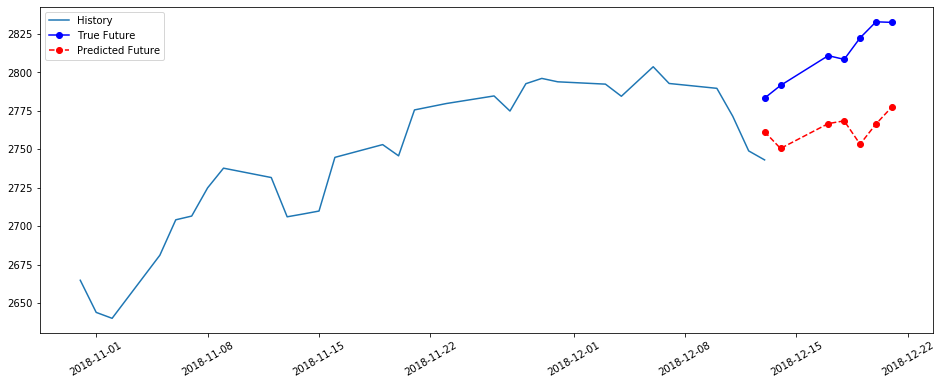

In [33]:
for xy, date in zip(val_data.take(3), val_dates.take(3)):
    
    x, y = xy
    x_dates, y_dates = date
#     print(x[0])
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    print(prediction_rescaled)
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

History date range: 2020-04-24 00:00:00, 2020-06-05 00:00:00
Future date range: 2020-06-08 00:00:00, 2020-06-16 00:00:00


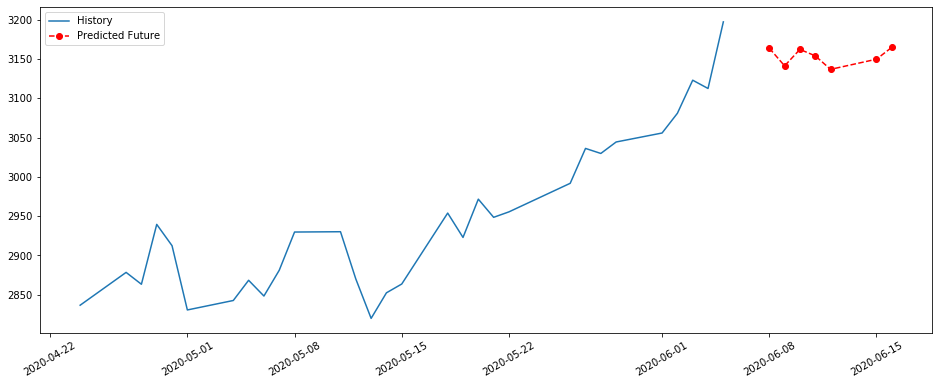

In [34]:
for x, date in zip(test_data.take(1), test_dates.take(1)):
    
    x_dates, y_dates = date
    history = x[0].numpy() [:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
#     print(history)
    prediction = model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), prediction=prediction_rescaled)